## In the name of God
## Big Data Management Final Project
## Teacher: Dr. Bohlouli
## Teaching Asisstants: Amirreza Mohammadi & Mohammad Nazeri
## Student: Reza Khaleghi
## Winter - Spring 2020

<div class="alert alert-block alert-info">
<b>Note:</b>  All of the stages done is referred to the document attached that defined this project
</div>

After extracting tweets from Twitter API by searching the hashtags `#iphone12` `#macbookpro16` `#airpods` the real challenge begins.
<br>We need is to create a spark session in order to make things right
<br>First things first, libraries need to be imported!

In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
import pandas as pd

Creating a simple spark session

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Next step is to import json dataset to our spark dataset. Because of too many annoying errors of spark that cannot handle parsing simple json file I decided to use a hand by bringing dear pandas here
> <br><br>1- By using pandas, we can easily parse json into a pandas dataframe
<br>2- Convert the pandas dataframe to spark dataframe by using function `createDataFrame(<variable name>)`
<br>3- Creating a view for future work (such as running queries etc.)
<br>4- Testing to see whether it works

In [3]:
df = pd.read_json("all_tweets/all_tweets.json")
spark_temp = spark.createDataFrame(df)
spark_temp.createOrReplaceTempView("temp")
# Examine the tables in the catalog again
# print(spark.catalog.listTables())
spark_temp.show()

+-------------------+-----------------------------+-----+
|                 id|                         text|label|
+-------------------+-----------------------------+-----+
|1242890135907098624|      #2019新発売 #Apple #...|    0|
|1242890287879467021|         #Apple #Airpods P...|    0|
|1242891040484401163|         Bonsoir je partic...|    1|
|1242891141214691334|#マラソンクーポン有 #Apple...|    0|
|1242892545056821254|         New fun game, whe...|    1|
|1242892785491095553|         RT @eBuyClub: #CO...|    1|
|1242893668480102404|         iPhone 12 Çentiks...|    1|
|1242894483798269953|         @Apple #airpods h...|    0|
|1242895114785239042|         10 Best Apple Air...|    1|
|1242895456516128775|         Ecco come portare...|    1|
|1242896173935087622|         Whoa! It’s an #Ap...|    0|
|1242897067699318784|         Whoa! It’s an #Ap...|    0|
|1242897075689250817|    昨年3,500万台のAirPods...|    1|
|1242897352228102144|       ปล่อย7500นะคะㅠㅠ ล...|    1|
|1242897787592667136|         Che

We can see a summary of this dataset. It consists of three columns: 
> <br>`id`: which is the tweet id for the given tweet
<br>`text`: corresponds to the exact text for the tweet
<br>`label`: shows if it has positive or negative meaning. `0` for negative and `1` for positive 
***

Just to be sure, need to check that there are 50-50 positive and negative tweets.
<br> Well. that was a lie. I wanted to show that I know this too :)

In [4]:
spark_temp.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  276|
|    1|  277|
+-----+-----+



<h3>Stage 2: Data Preprocessing</h3>

<br>Here comes the second part. In this part we converted the spark dataframe to pandas dataframe for two reasons:
<br>1. Getting the text for each row in spark dataframe is too slow (as far as I know because of the RDD structure)
<br>2. It is easier to it in this way. dataset is not too big.
<br>So I converted the spark dataframe to pandas by using `toPandas()` function. Sounds like it's from java isn't it?

In [5]:
query = "select text,label from temp"
all_ = spark.sql(query).toPandas()

Let's wash away their ornamets and let them show their true nature!
> <br>1. Getting rid of any character that is not english
<br>2. Wat the hack those links do ova der?
<br>3. Really? Numbers?
<br>4. turn some slang phrases into something meaningful

In [6]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^A-Z^a-z^\d^\s^!"#$%&\'\(\)*+,\-./:;<=>?@\[\\\]^_`{|}~]', '', text)
    text = re.sub(r'https\b.*\b', ' ', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text) 
    text = text.strip(' ')
    return text
all_['text'] = all_['text'].apply(lambda x: clean_text(x))
# all_.head(10)


<div class="alert alert-block alert-info">
Wanna know the most common terms used in those tweets?
<br>And even want to know what terms used for positive tweets?
<br>Even for negative tweets??
<br>Jeeezz. Okay. here's the code for ya
</div>

(-0.5, 399.5, 199.5, -0.5)

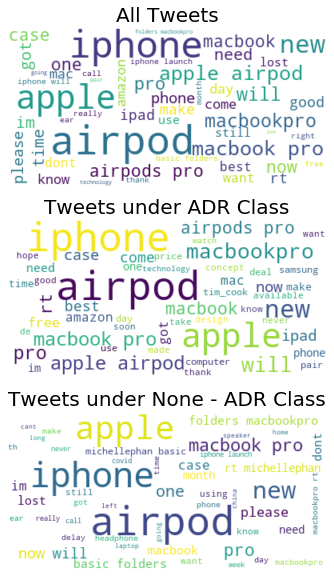

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Start with one review:
df_ADR = all_[all_['label']==1]
df_NADR = all_[all_['label']==0]
tweet_All = " ".join(review for review in all_.text)
tweet_ADR = " ".join(review for review in df_ADR.text)
tweet_NADR = " ".join(review for review in df_NADR.text)

fig, ax = plt.subplots(3, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(tweet_All)
wordcloud_ADR = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(tweet_ADR)
wordcloud_NADR = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(tweet_NADR)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=20)
ax[0].axis('off')
ax[1].imshow(wordcloud_ADR, interpolation='bilinear')
ax[1].set_title('Tweets under ADR Class',fontsize=20)
ax[1].axis('off')
ax[2].imshow(wordcloud_NADR, interpolation='bilinear')
ax[2].set_title('Tweets under None - ADR Class',fontsize=20)
ax[2].axis('off')

<h3>Stage 3: Training the Model</h3>

<br>Do we need the `id` column? ofcourse not! Why? Because it has no information for us. It is not useful in the training process

In [8]:
all_[['text','label']].head()

,text,label
0,apple airpods pro mwpj a bluetooth apple airpo...,0
1,apple airpods pro for only open box return not...,0
2,bonsoir je participe avec plaisir ce super con...,1
3,apple airpods with charging case mvnj a kkndp psr,0
4,new fun game where the strangest place you hav...,1


<b>Oh ^&*!@. I'm still using `pandas`. Okay Okay!</b>
<br>Enough of the funny parts. Let's get down to business!

In [9]:
# converting the cleansed pandas dataframe into sparky one
cl = spark.createDataFrame(pd.DataFrame(all_[['text','label']]))

By the power of the Gods, Split those dataset into a 60-40 train-test subset!

In [10]:
(trainingData, testData) = cl.randomSplit([0.7, 0.3])

So, before we train the data, we need to turn those texts into numbers, no?
<br> I just only cleansed the text using pandas, the important part for NLP processing lies here
<br> To do this, we need to create a pipeline as discussed in the class to define the stages of the process. So Here's the pipeline:
<div class="alert alert-block alert-info"; style="text-align: center"> <b>Tokenizing $\rightarrow$ Term Frequency $\rightarrow$ Inverse-Term Frequency $\rightarrow$ Classifier Method</b> </div>
<br>And then we create the model by training the train data

We tried to use 3 methods of `Naive Bayes`, `Logistic Regression` and `Random Forest` Classifiers to see which one of them has something to say.

### Naive Bayes

In [11]:
# importing required libraries
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression

# Configuring a ML pipeline, which consists of four stages: tokenizer, hashingTF, IDF and Naive Bayes Classifier.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(minDocFreq=3, inputCol="rawFeatures", outputCol="features")

# Initializing Naive Bayes model
nb = NaiveBayes()

# Beautiful Pipeline Architecture. Isn't it?
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])

# Training the model
model = pipeline.fit(trainingData)

Now it's time to see how reliable our model is. So we transform it on our test data

In [12]:
predictions = model.transform(testData)

# Select example rows to display.
a = predictions.select("text", "label", "prediction")
a.createOrReplaceTempView("a")
a.show(5,False)

So what's the accuracy of our model?

In [13]:
# Let's import evaluator first
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
# Getting the accuracy
# Too many digits? Okay I just summarize it to 3 float digits
print('{:.3f}'.format(evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})))

0.5955555555555555


Isn't the accuracy enough for you? You trying to say you are a machine learning expert?
<br> Sure you are! Okay here you are. `Accuracy`, `Precision`, `Recall` and `F-measure`
<br>Why bringing accuracy again? To prove you that these formula are correct.
<br> I tried to use built-in method to get `condusion matrix` but as this glorious `spark` will bring us unknown errors I tried to get them by myself! 
<bR>Also I tried to show I can run a query and get the result to use it for further processes.

In [14]:
# True Positive
query = "select count(label) from a where label = 1 and prediction = 1"
r = spark.sql(query)
tp = r.collect()[0][0]

In [15]:
# True Negative
query = "select count(label) from a where label = 0 and prediction = 0"
r = spark.sql(query)
tn = r.collect()[0][0]

In [16]:
# False Positive
query = "select count(label) from a where label = 0 and prediction = 1"
r = spark.sql(query)
fp = r.collect()[0][0]

In [17]:
# False Negative
query = "select count(label) from a where label = 1 and prediction = 0"
r = spark.sql(query)
fn = r.collect()[0][0]

In [18]:
print(tp,tn,fp,fn)
print(tp+tn+fp+fn)

67 67 49 42
225


In [19]:
# Using each term formula to calculate
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = (2*precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+fp+fn+tn)
print("Precision = ", '{:.3f}'.format(precision))
print("Recall = ", '{:.3f}'.format(recall))
print("Accuracy = ", '{:.3f}'.format(accuracy))
print("F-measure = ", '{:.3f}'.format(f1))

Precision =  0.578
Recall =  0.615
Accuracy =  0.596
F-measure =  0.596


I'm beginning to wonder why the metrics are not as expected. It varies between 60 to 70 which is not even good. let's try another method

### Logistic Regression

In [20]:
# Logistic Regression
lr = LogisticRegression()

# Pipeline Architecture
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

# Train model.
model = pipeline.fit(trainingData)

In [21]:
predictions = model.transform(testData)

# Select example rows to display.
a = predictions.select("text", "label", "prediction")
a.createOrReplaceTempView("a")
a.show(5,False)

In [22]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('{:.3f}'.format(evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})))

0.5634033802454856

In [23]:
# True Positive
query = "select count(label) from a where label = 1 and prediction = 1"
r = spark.sql(query)
tp = r.collect()[0][0]

In [24]:
# True Negative
query = "select count(label) from a where label = 0 and prediction = 0"
r = spark.sql(query)
tn = r.collect()[0][0]

In [25]:
# False Positive
query = "select count(label) from a where label = 0 and prediction = 1"
r = spark.sql(query)
fp = r.collect()[0][0]

In [26]:
# False Negative
query = "select count(label) from a where label = 1 and prediction = 0"
r = spark.sql(query)
fn = r.collect()[0][0]

In [27]:
print(tp,tn,fp,fn)
print(tp+tn+fp+fn)

75 53 63 34
225


In [28]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = (2*precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+fp+fn+tn)
print("Precision = ", '{:.3f}'.format(precision))
print("Recall = ", '{:.3f}'.format(recall))
print("Accuracy = ", '{:.3f}'.format(accuracy))
print("F-measure = ", '{:.3f}'.format(f1))

Precision =  0.543
Recall =  0.688
Accuracy =  0.569
F-measure =  0.607


Looks like logistic regression isn't giving good results too. For the final step I'm gonna use `Random Forest`

### Random Forest Classifier

In [29]:
# Random Forest Classifier
lr = RandomForestClassifier()

# Pipeline Architecture
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

# Train model.
model = pipeline.fit(trainingData)

In [30]:
predictions = model.transform(testData)

# Select example rows to display.
a = predictions.select("text", "label", "prediction")
a.createOrReplaceTempView("a")
a.show(5,False)

In [31]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('{:.3f}'.format(evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})))

0.39816393442622955

In [32]:
# True Positive
query = "select count(label) from a where label = 1 and prediction = 1"
r = spark.sql(query)
tp = r.collect()[0][0]

In [33]:
# True Negative
query = "select count(label) from a where label = 0 and prediction = 0"
r = spark.sql(query)
tn = r.collect()[0][0]

In [34]:
# False Positive
query = "select count(label) from a where label = 0 and prediction = 1"
r = spark.sql(query)
fp = r.collect()[0][0]

In [35]:
# False Positive
query = "select count(label) from a where label = 1 and prediction = 0"
r = spark.sql(query)
fn = r.collect()[0][0]

In [36]:
print(tp,tn,fp,fn)
print(tp+tn+fp+fn)

94 14 102 15
225


In [37]:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = (2*precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+fp+fn+tn)
print("Precision = ", '{:.3f}'.format(precision))
print("Recall = ", '{:.3f}'.format(recall))
print("Accuracy = ", '{:.3f}'.format(accuracy))
print("F-measure = ", '{:.3f}'.format(f1))

Precision =  0.480
Recall =  0.862
Accuracy =  0.480
F-measure =  0.616


Okay. Looks like our attempt was in vain.
<br>Seriously no. The first reason is the dataset is too small. Machine Learning methods works just fine with larger datasets. So we cannot expect a very good with a small dataset. The only thing we can do is to play with splitting ratio (not too few test with too many train though etc.) to increase the make those metrics better.
<br> Between these three methods, Naive Bayes has done a better due to its frequency basis and probability it use.

### Last words

That was a challenging project for me.
<br>New way to handle data. specially streaming data. (we didn't work like this but it is possible)
<br>In my opinion, spark can be a very good platform to work but it has not a good reference to make things transparent.
<br>Also the project document was not very clear. Specially in part 2. Didn't clearly mentioned that whether we can use nltk library to do the NLP process. Also it could be better to give more clear references or examples. Original document is too much for a student that want to work with a drop of it.
<br>But thank you for your help to do a practical work in this course.

<div class="alert alert-block alert-info">
<b>Note:</b> I tried to describe my code without making you exhausted. If you feel offended I apologize.
</div>